In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.fft
from scipy.special import factorial
import math
# import csv
from matplotlib import rc, rcParams


In [ ]:

def fitlin(x, y, sig):
    '''
    Performs a least-squares linear fit

    Parameters
    ----------
    x : array
        The independent data
    y : array
        The dependent data
    sig : array
        The uncertainty in y

    Returns
    ----------
    popt : array
        Optimal values for the parameters
    perr : array
        The uncertainty on the fit parameters
    chisq : float
        The value of chi-squared
    yfit : array
        The values of the fitted line at each x
    '''

    ### See Bevington and Robinson Ch. 6 (p. 114)

    # TLDR: by minimizing the chi-squared, you get a system of equations
    ###         term3 = b * term1 + m * term5
    ###         term4 = b * term5 + m * term2
    ###     this equation can be solved by taking determinants
    ###     the inverse of the matrix (the curvature matrix of a linear ftn)
    ###         ( term1 term5 )
    ###         ( term5 term2 )
    ###     is the covariance matrix, and the diagonal terms are the fit errors
    ###     the full formulas can be found on page 114 of Bevington

    term1 = np.sum(    1 / sig**2 )
    term2 = np.sum( x**2 / sig**2 )
    term3 = np.sum(    y / sig**2 )
    term4 = np.sum(  x*y / sig**2 )
    term5 = np.sum(    x / sig**2 )

    delta = term1*term2 - term5**2

    b = ( term2*term3 - term5*term4 ) / delta
    m = ( term1*term4 - term5*term3 ) / delta
    popt = np.array([b, m])

    berr = np.sqrt( term2 / delta )
    merr = np.sqrt( term1 / delta )
    perr = np.array([berr, merr])

    yfit = b + m*x

    chisq = np.sum( ( (y - yfit) / sig )**2 )

    return popt, perr, chisq, yfit

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.autolayout'] = True  # Ensures proper spacing
# Set equal aspect ratio and axis limits in the plotting code instead of rcParams

In [ ]:
# with open('data/exp_list_0.csv', mode ='r') as file: # "ElsieWiddowsonFileC051.txt"
#     lines = file.readlines()
#     lines = [[float(i) for i in line.split(",")] for line in lines]



with open('data/Real/392_6/392-6mA_20k_10s_3u_10-29.txt', mode ='r') as file: # "ElsieWiddowsonFileC051.txt"
    lines = file.readlines()
    lines = [[float(i) for i in line.split("\t")] for line in lines]

# print(lines)

lines = np.array(lines)

avgx = sum(lines[:,0] / len(lines))
avgy = sum(lines[:,1] / len(lines))
plt.plot(lines[:,0], lines[:,1], lw=0.1)
plt.plot(avgx, avgy, 'r+', markersize=10, label='Mean position')
plt.xlabel('QPD X Voltage (V)')
plt.ylabel('QPD Y Voltage (V)') 
plt.title('Brownian Motion of Trapped Particle at 392.6mA Laser Input Power')


plt.legend()
plt.show()






In [ ]:
dists = np.sqrt((lines[:,0] - avgx) ** 2 + (lines[:,1] - avgy) ** 2)
freqs = scipy.fft.fft(dists) / len(dists)  # Normalize by number of points
freqs = freqs / 10.0  # Additional normalization by total time duration (10 seconds)
plt.loglog(abs(freqs[100:10**5]), lw=0.4)
plt.title('Log-log plot of trapped bead power spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V²/Hz)')



In [22]:
import os
import glob

# Get all txt files in xyscan directory, excluding Settings files
currents = [10,12]  # List of currents to process, 
xyscan_files = []
for current in currents:
    xyscan_files.extend([f for f in glob.glob(f'data/QPD/{current}*.txt')
                        if not (f.endswith('Settingsx.txt') or f.endswith('Settingsy.txt') or 
                               f.endswith('SettingsX.txt') or f.endswith('SettingsY.txt'))])

class QPDScan:
  def __init__(self, name, data):
    self.name = name
    self.data = data
    self.panda = pd.DataFrame(data)

all_data = []
for filename in xyscan_files:
    with open(filename, mode='r') as file:
        lines = file.readlines()
        # Convert each line into list of floats by splitting on tabs
        data = [[float(val) for val in line.strip().split('\t')] for line in lines]
        # Transpose to get columns 
        data = list(map(list, zip(*data)))

        # Now save the data to a QPDScan class object ready for reference later
        scan = QPDScan(name=os.path.basename(filename), data=data)
        all_data.append(scan)
# Now `all_data` contains a list of QPDScan objects, each with its respective data.
# Example of accessing the data:
for scan in all_data:
    print(f"Scan Name: {scan.name}")
    scan.panda = scan.panda.transpose()
    print(scan.panda.head())  # Print first few rows of the DataFrame


    # plt.figure()
    # plt.plot(np.arange(len(data[0])), data[0], label = 'x data')  # First two columns are x,y coordinates
    # plt.plot(np.arange(len(data[1])), data[1], label = 'y data')  # First two columns are x,y coordinates
    # plt.plot(np.arange(len(data[2])), data[2], label = 'x data strain')  # First two columns are x,y coordinates
    # plt.plot(np.arange(len(data[3])), data[3], label = 'y data strain')
    # plt.title(os.path.basename(filename))
    # plt.legend()
    # plt.show()

#all_data = np.array(all_data)


Scan Name: 100X.txt
          0         1         2        3
0  0.003507  0.103055  0.267654  10.1090
1  0.004164  0.104041  0.267654  10.1090
2  0.003507  0.103384  0.267654  10.1094
3  0.003836  0.103384  0.266997  10.1094
4  0.004164  0.103712  0.266997  10.1097
Scan Name: 100Y.txt
          0         1        2         3
0  0.004164  0.102398  10.1399  0.254184
1  0.004164  0.103055  10.1402  0.254184
2  0.004821  0.103384  10.1402  0.254184
3  0.004821  0.102726  10.1406  0.253198
4  0.005150  0.102726  10.1406  0.253198
Scan Name: 1201Y.txt
          0         1        2         3
0  0.008435  0.175991  10.0795  0.218044
1  0.008435  0.175663  10.0791  0.217716
2  0.008435  0.175334  10.0795  0.217716
3  0.008764  0.175663  10.0795  0.217387
4  0.008435  0.176648  10.0791  0.217387
Scan Name: 120X.txt
          0         1         2        3
0  0.006464  0.176320  0.236443  10.7921
1  0.006464  0.175663  0.236771  10.7918
2  0.006135  0.175334  0.235786  10.7915
3  0.006135  0.17

In [8]:
for scan in all_data:
    print(f"Scan Name: {scan.name}")
    print(scan.panda.head())  

Scan Name: 100X.txt
          0         1         2        3
0  0.003507  0.103055  0.267654  10.1090
1  0.004164  0.104041  0.267654  10.1090
2  0.003507  0.103384  0.267654  10.1094
3  0.003836  0.103384  0.266997  10.1094
4  0.004164  0.103712  0.266997  10.1097
Scan Name: 100Y.txt
          0         1        2         3
0  0.004164  0.102398  10.1399  0.254184
1  0.004164  0.103055  10.1402  0.254184
2  0.004821  0.103384  10.1402  0.254184
3  0.004821  0.102726  10.1406  0.253198
4  0.005150  0.102726  10.1406  0.253198
Scan Name: 1201Y.txt
          0         1        2         3
0  0.008435  0.175991  10.0795  0.218044
1  0.008435  0.175663  10.0791  0.217716
2  0.008435  0.175334  10.0795  0.217716
3  0.008764  0.175663  10.0795  0.217387
4  0.008435  0.176648  10.0791  0.217387
Scan Name: 120X.txt
          0         1         2        3
0  0.006464  0.176320  0.236443  10.7921
1  0.006464  0.175663  0.236771  10.7918
2  0.006135  0.175334  0.235786  10.7915
3  0.006135  0.17

In [23]:
# Reduce size
for scan in all_data:
    scan.panda = scan.panda.iloc[175000:225000]

Scan Name: 100X.txt


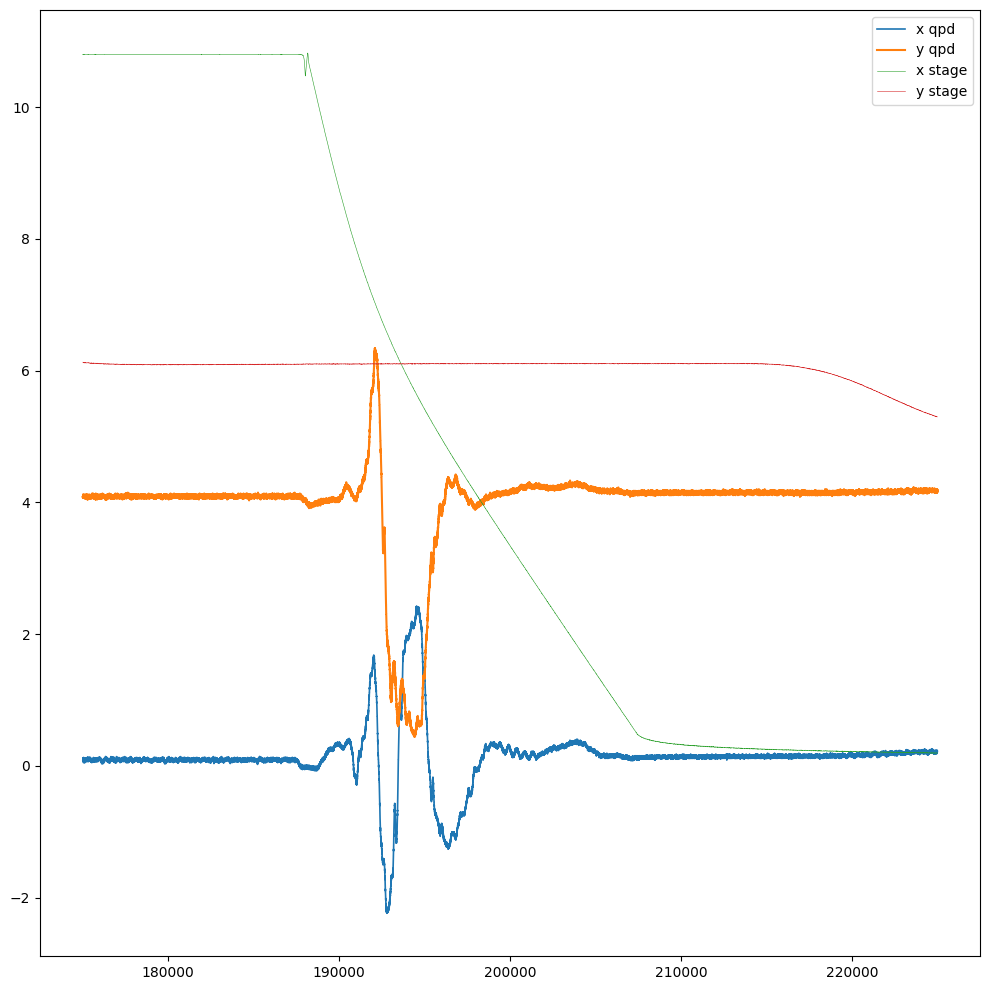

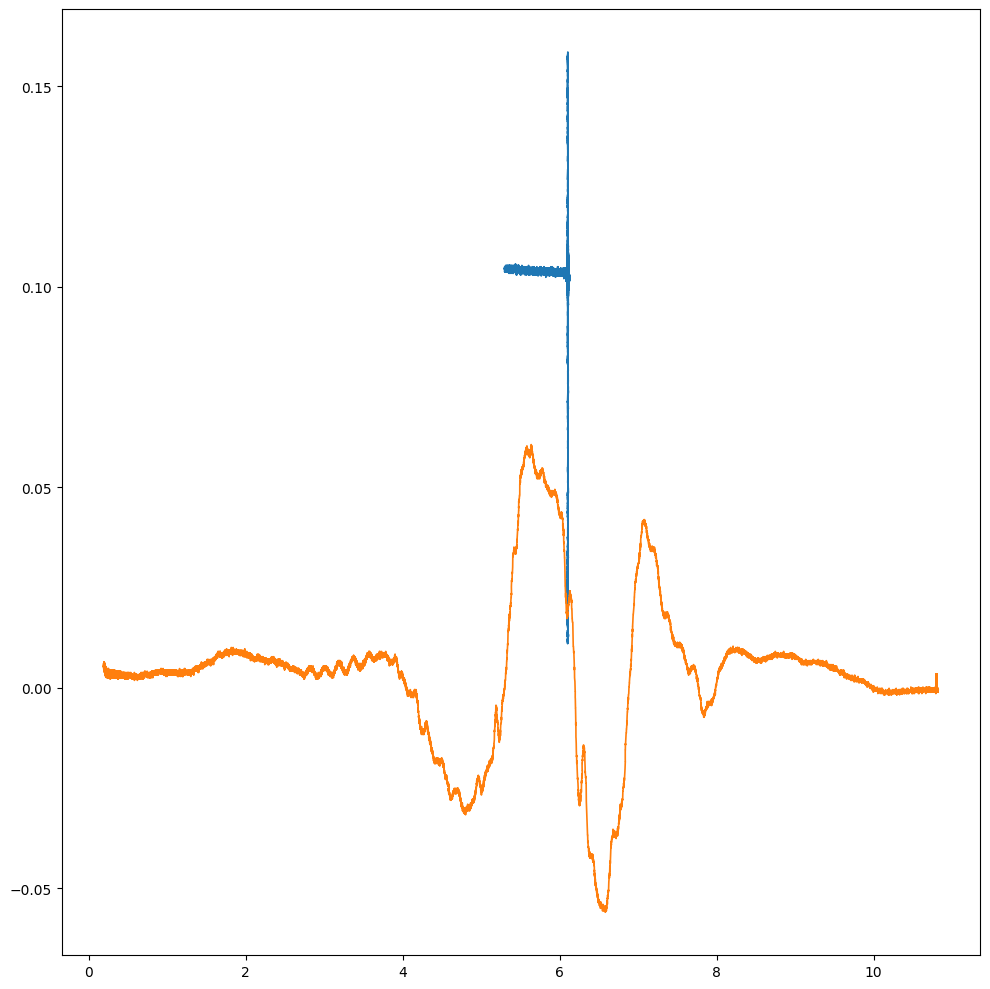

Scan Name: 100Y.txt


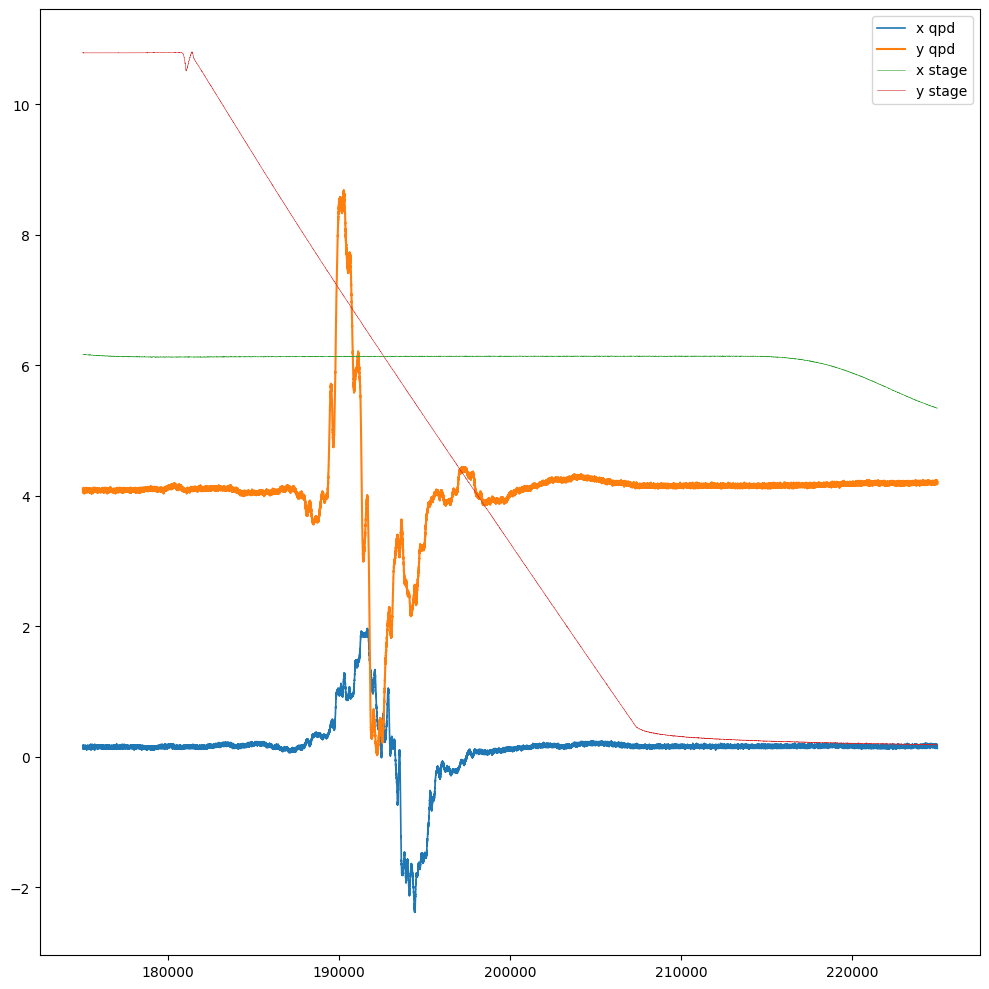

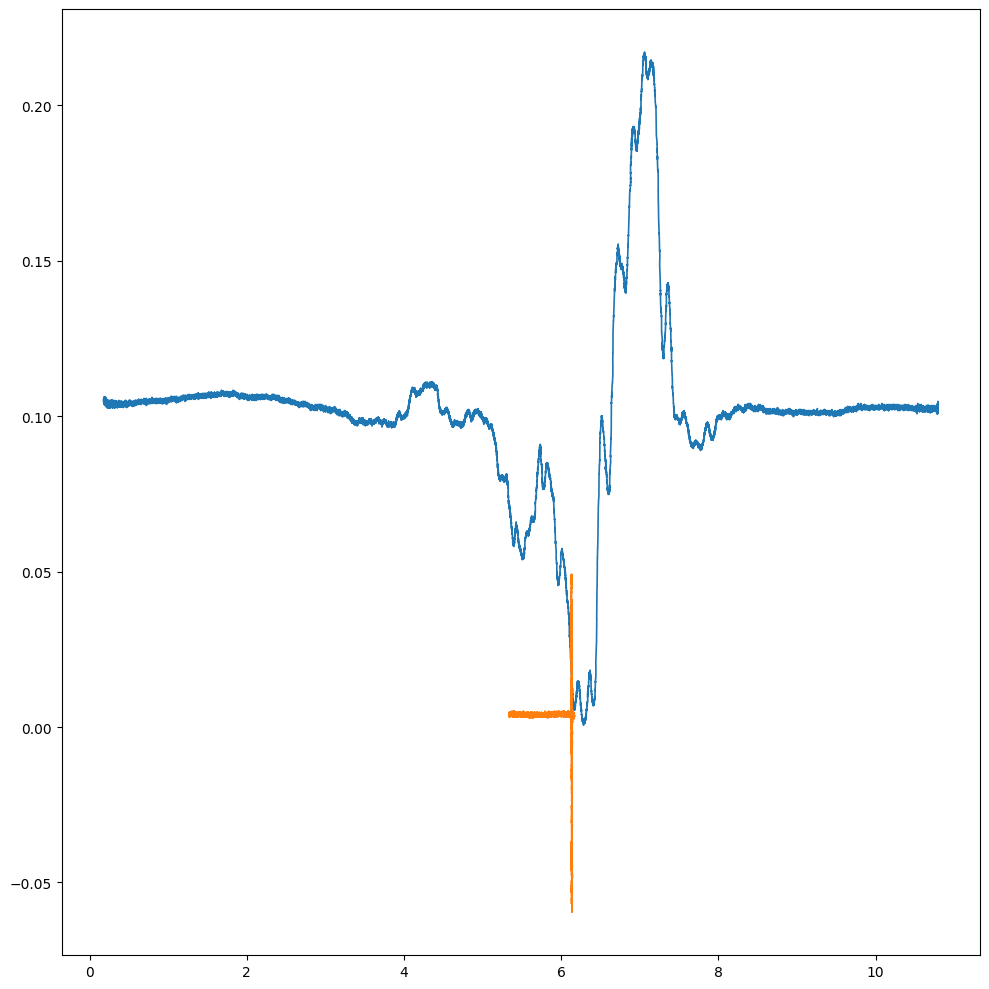

Scan Name: 1201Y.txt


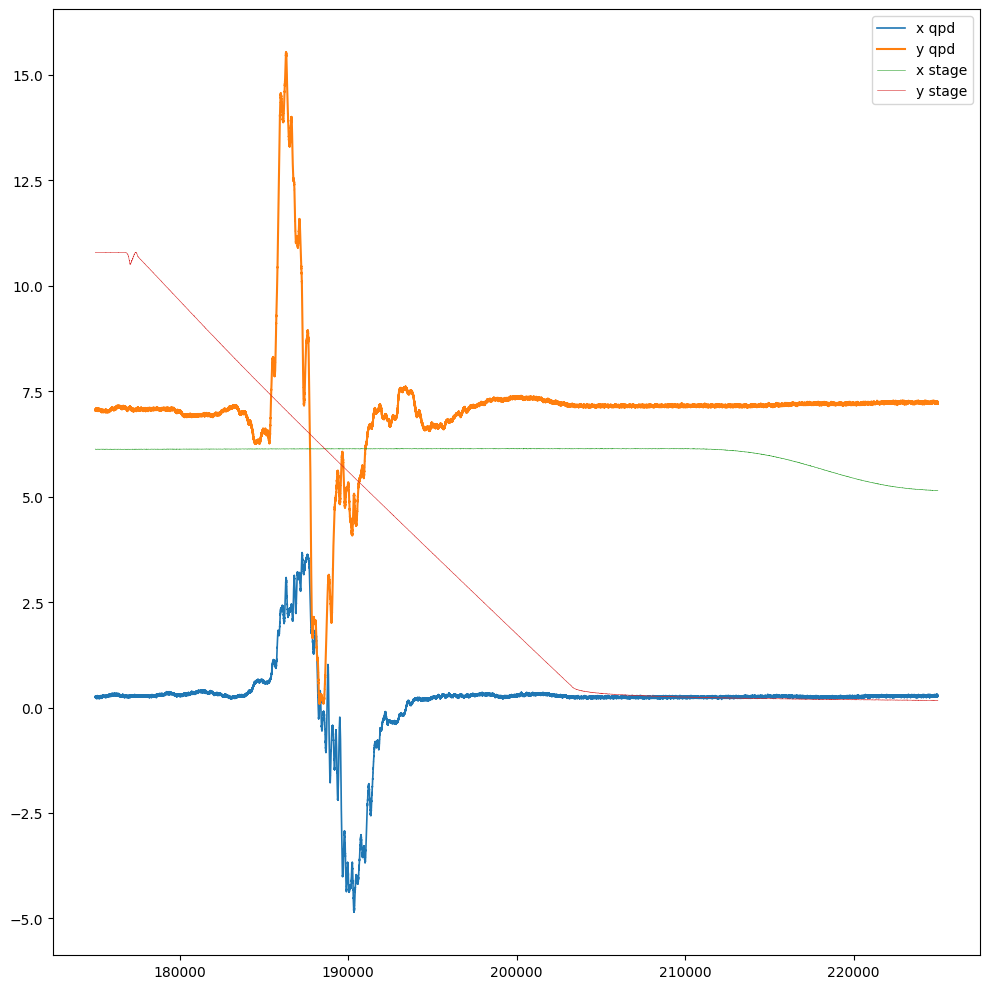

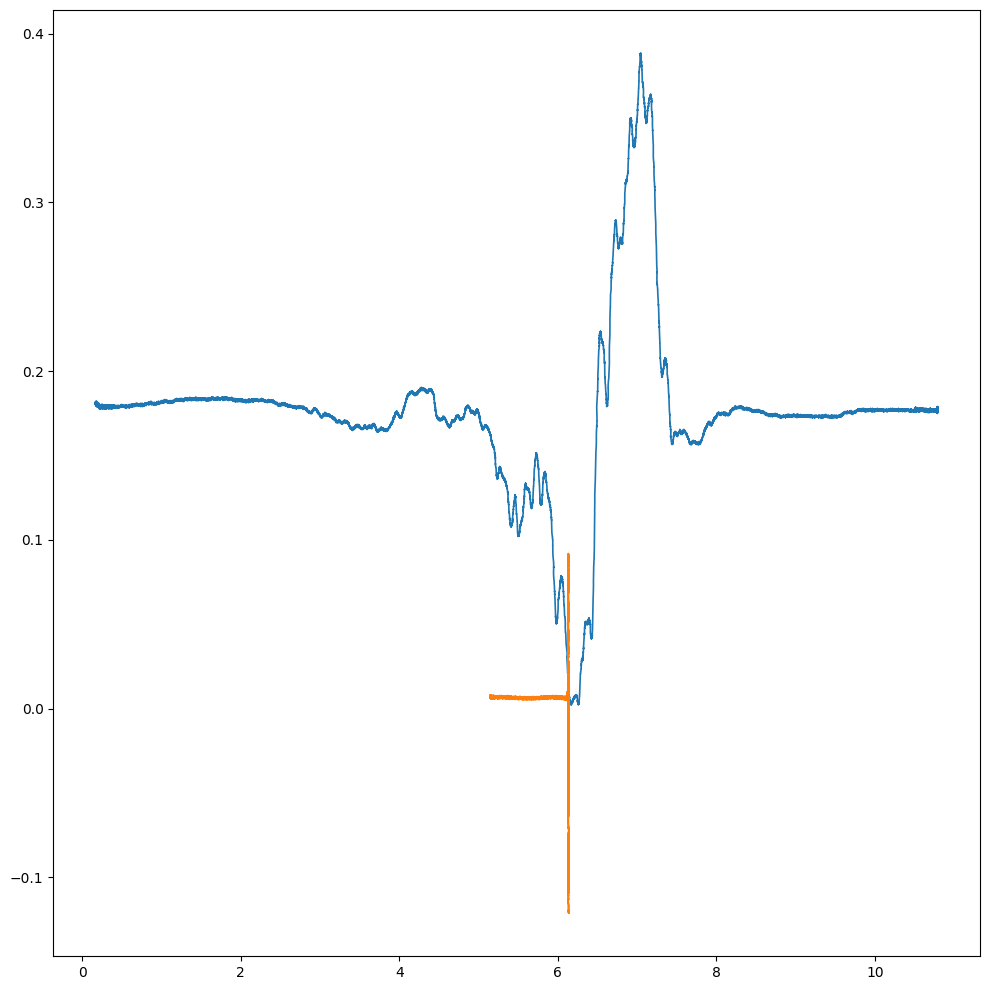

Scan Name: 120X.txt


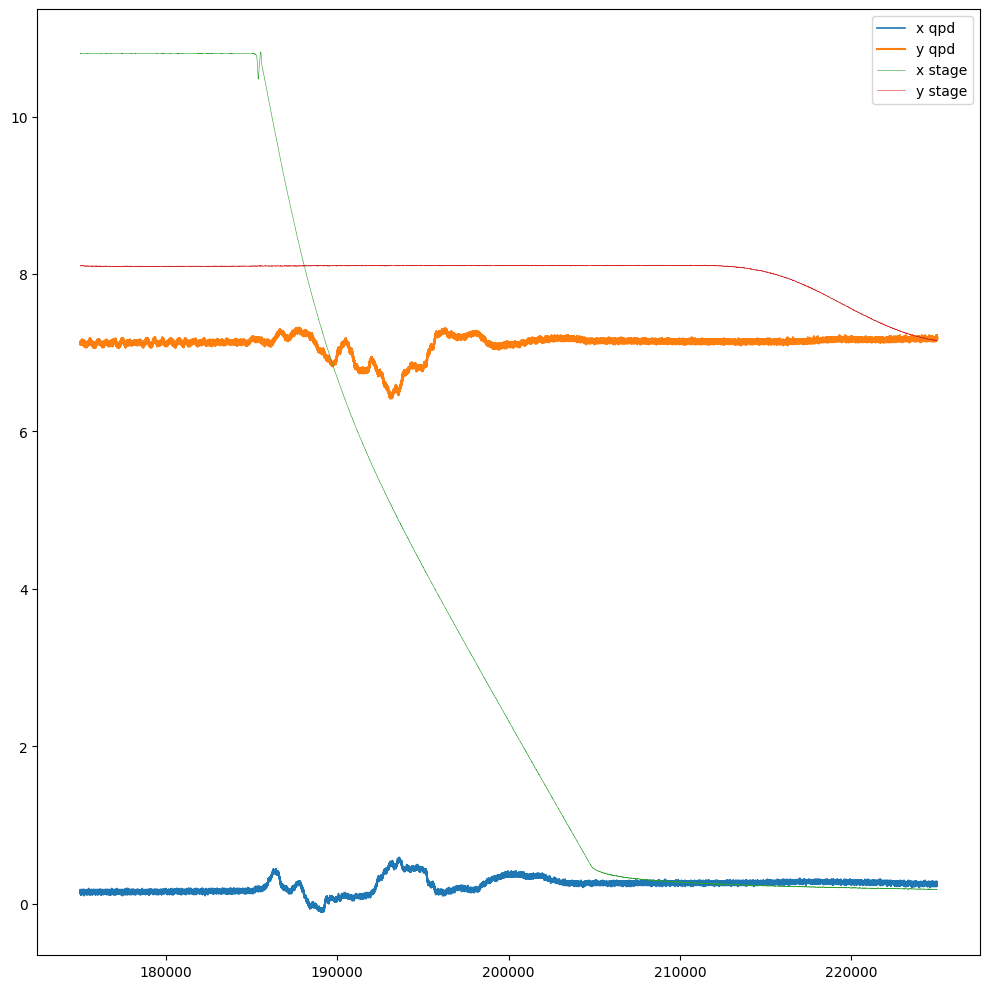

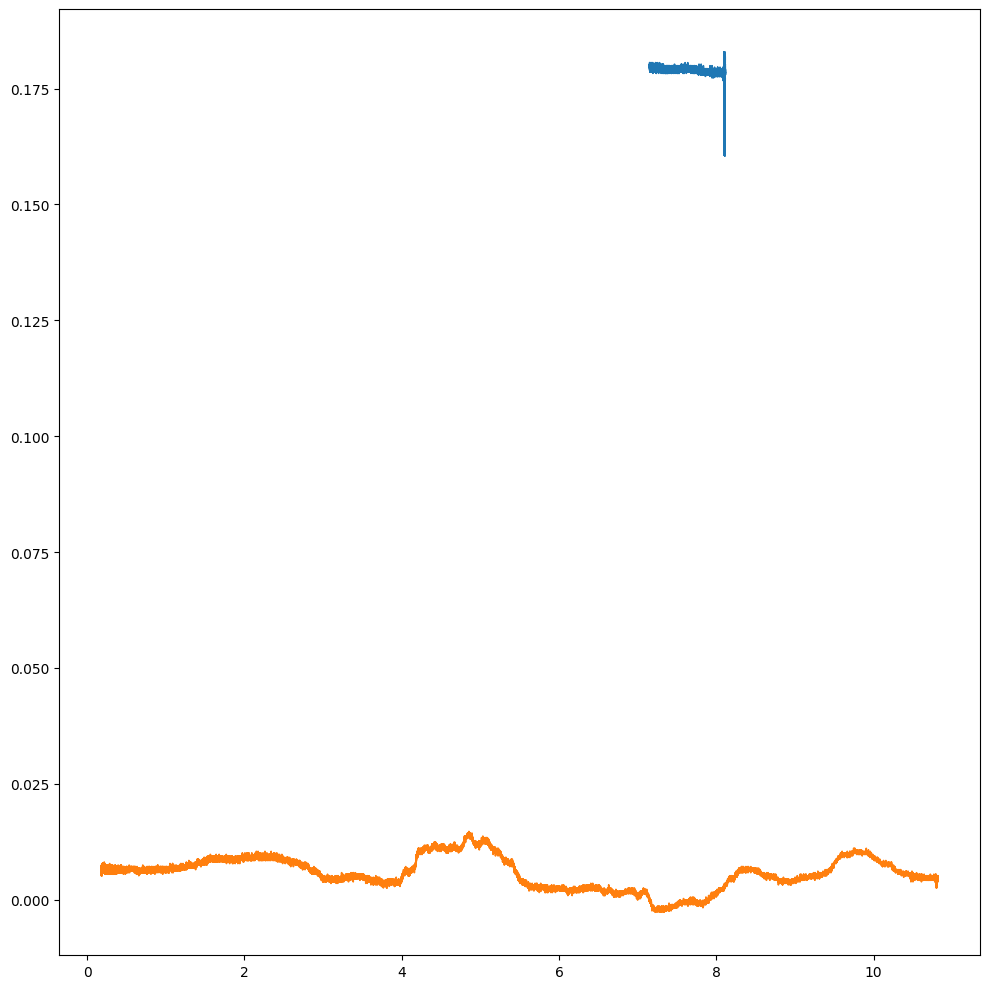

In [24]:
for scan in all_data:
    print(f"Scan Name: {scan.name}")
    plt.plot(scan.panda[0]*40, label = 'x qpd', lw=1.2)
    plt.plot(scan.panda[1]*40, label = 'y qpd')
    plt.plot(scan.panda[2], label = 'x stage', lw=0.4)
    plt.plot(scan.panda[3], label = 'y stage', lw=0.4)
    plt.legend()
    plt.show()

    plt.plot(scan.panda[3],scan.panda[1], label = 'y qpd vs stage y', lw=1.2)
    plt.plot(scan.panda[2],scan.panda[0], label = 'x qpd vs stage x', lw=1.2)
    plt.show()

In [ ]:
ind = 5
print(all_data[ind], 1 if 'y' in xyscan_files[ind] or 'Y' in xyscan_files[ind] else 0)
specific = all_data[ind][1]
# plt.plot(range(len(specific)), specific)
plt.plot(all_data[ind][2], specific)
plt.plot(all_data[ind][2][87500:91500], specific[87500:91500])
plt.show()
plt.plot(range(len(specific))[87500:91500], specific[87500:91500])
popt, perr, chisq, yfit = fitlin(all_data[ind][2][87500:91500], specific[87500:91500], np.array([0]*(91500-87500)))
print(popt, perr)
plt.plot(all_data[ind][0] * 10, label='x qpd')
plt.plot(all_data[ind][1] * 10, label='y qpd')
plt.plot(all_data[ind][2], label='x stage')
plt.plot(all_data[ind][3], label='y stage')
# line_fit_intervals = [[[92000,101500]], [165000,169000], [153500,157500]]
plt.legend(loc="upper right",fontsize=15,ncol = 1)
line_fit_intervals = {'0,1'}

In [ ]:
xx = {'100': (-0.00202372,	-0.00246727), '193': (-0.00656128,	-0.01077355), '292': (-0.011165,	-0.02091801), '392': (-0.01130522,	-0.02648227)}
# xx_series = pd.Series(data=xx) 
yy = {'100': (-0.00109493,	-0.00179321), '193': (-0.004255306,	-0.00838348), '292': (-0.00843359,	-0.0218029), '392': (-0.012513,	-0.0267312)}
# yy_series = pd.Series(data=yy)

In [ ]:
scaling_factor = 50/20000
xx = np.array([-0.00202372, -0.00656128, -0.011165, -0.01130522])
xy = np.array([-0.00246727, -0.01077355, -0.02091801, -0.02648227])
yx = np.array([-0.00109493, -0.004255306, -0.00843359, -0.012513])
yy = np.array([-0.00179321, -0.00838348, -0.0218029, -0.0267312])

In [ ]:
tantheta1 = yx/xx
tantheta2 = xy/yy

In [ ]:
print(np.arctan(tantheta1) * 180/np.pi, np.arctan(tantheta2)* 180/np.pi)